# Esercizi 07 - Insieme canonico, Monte Carlo

In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

<span style="color:blue">In queste simulazioni sono fissati il numero di particelle $N$, il volume del sistema $V$ e la sua temperatura $T$ (invece dell'energia interna, che era fissata nell'esercitazione 4).</span>

<span style="color:blue">
    
Le condizioni considerate per simulare le tre fasi del sistema sono:
    
- fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c = 2.2$)
- fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c = 2.5$)
- fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c = 5.0$)
    
</span>    

<span style="color:blue">
Per l'argon, le unità di Lennard-Jones sono:
    
- $\sigma=0.34 \; \text{nm}$, unità di lunghezza
- $\epsilon/k_B=120 \; \text{K}$, unità di temperatura
- $m=39.948 \; \text{amu}$, unità di massa
</span>


## Equilibrio

Ho cominciato studiando l'equilibrazione del sistema. Ricordo che è stato implementato il calcolo delle tail corrections per l'energia potenziale e per la pressione.

### Solido

Per la fase solida ho ottenuto un'accettazione <span style="color:red">$\alpha\approx0.472291$ con  $\delta=0.12$</span >.

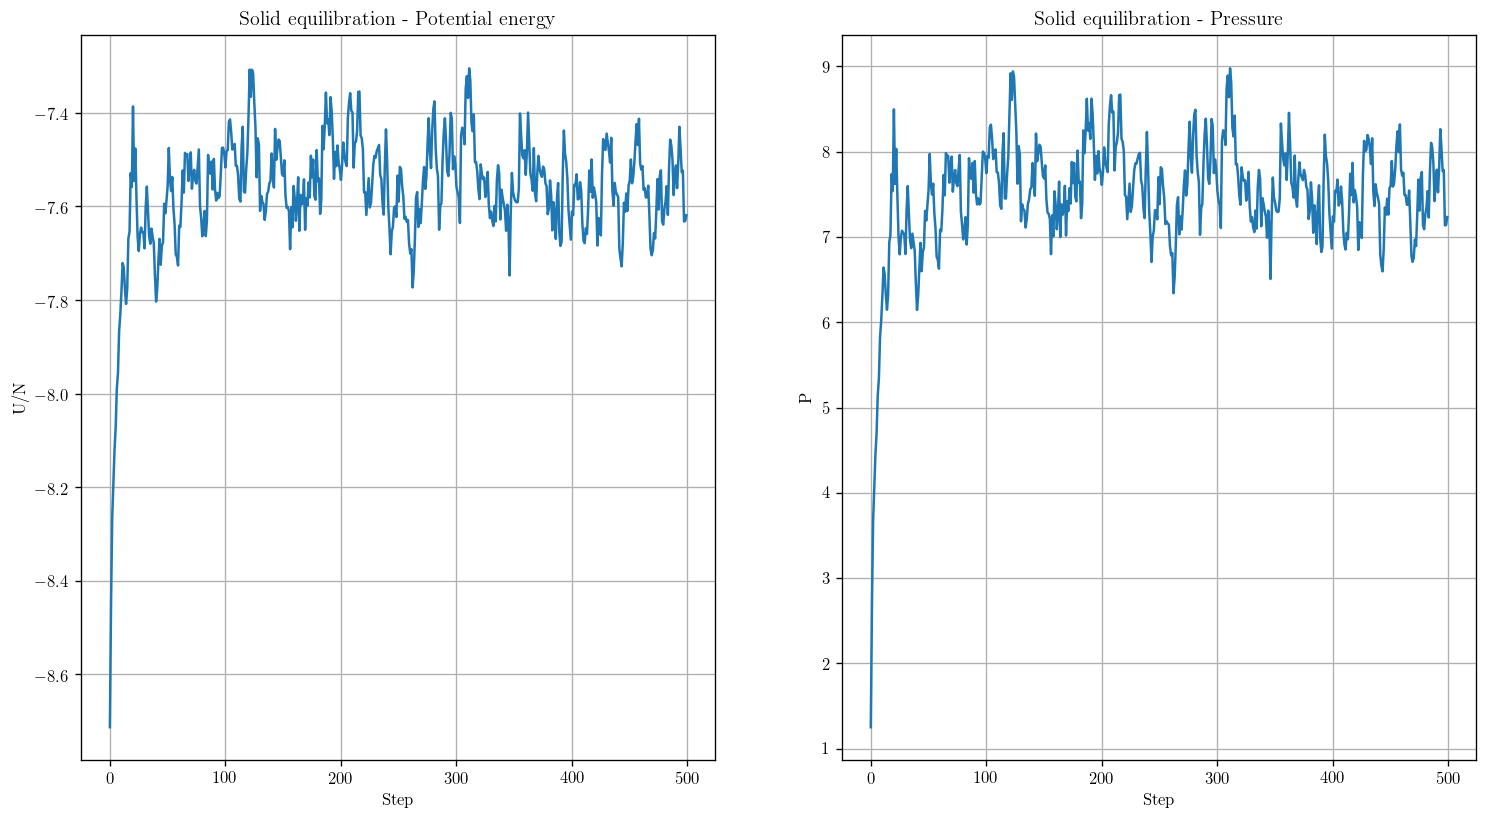

In [2]:
eq_Uinst=np.loadtxt("Ex_07_1/Equilibration/Solid/output_Uinst.dat", max_rows=500) #5000 valori nel file
eq_Pinst=np.loadtxt("Ex_07_1/Equilibration/Solid/output_Pinst.dat", max_rows=500)


plt.rc('text', usetex=True)
plt.rc('font', family='serif')


fig, ax=plt.subplots(1,2, figsize=(15,8), dpi=120)

ax[0].plot(eq_Uinst)
ax[1].plot(eq_Pinst)

ax[0].set_title("Solid equilibration - Potential energy")
ax[1].set_title("Solid equilibration - Pressure")
ax[0].set_ylabel("U/N")
ax[0].set_xlabel("Step")
ax[1].set_ylabel("P")
ax[1].set_xlabel("Step")
ax[0].grid(True)
ax[1].grid(True)
    
plt.show()

Come si può vedere dai grafici soprastanti, il sistema si trovava già in equilibrio dopo <span style="color:red">$N_{eq}=200$ step</span>.

### Liquido

Per quanto riguarda la fase liquida, ho ottenuto un'accettazione <span style="color:red">$\alpha\approx0.51$ con $\delta=0.2$</span>.

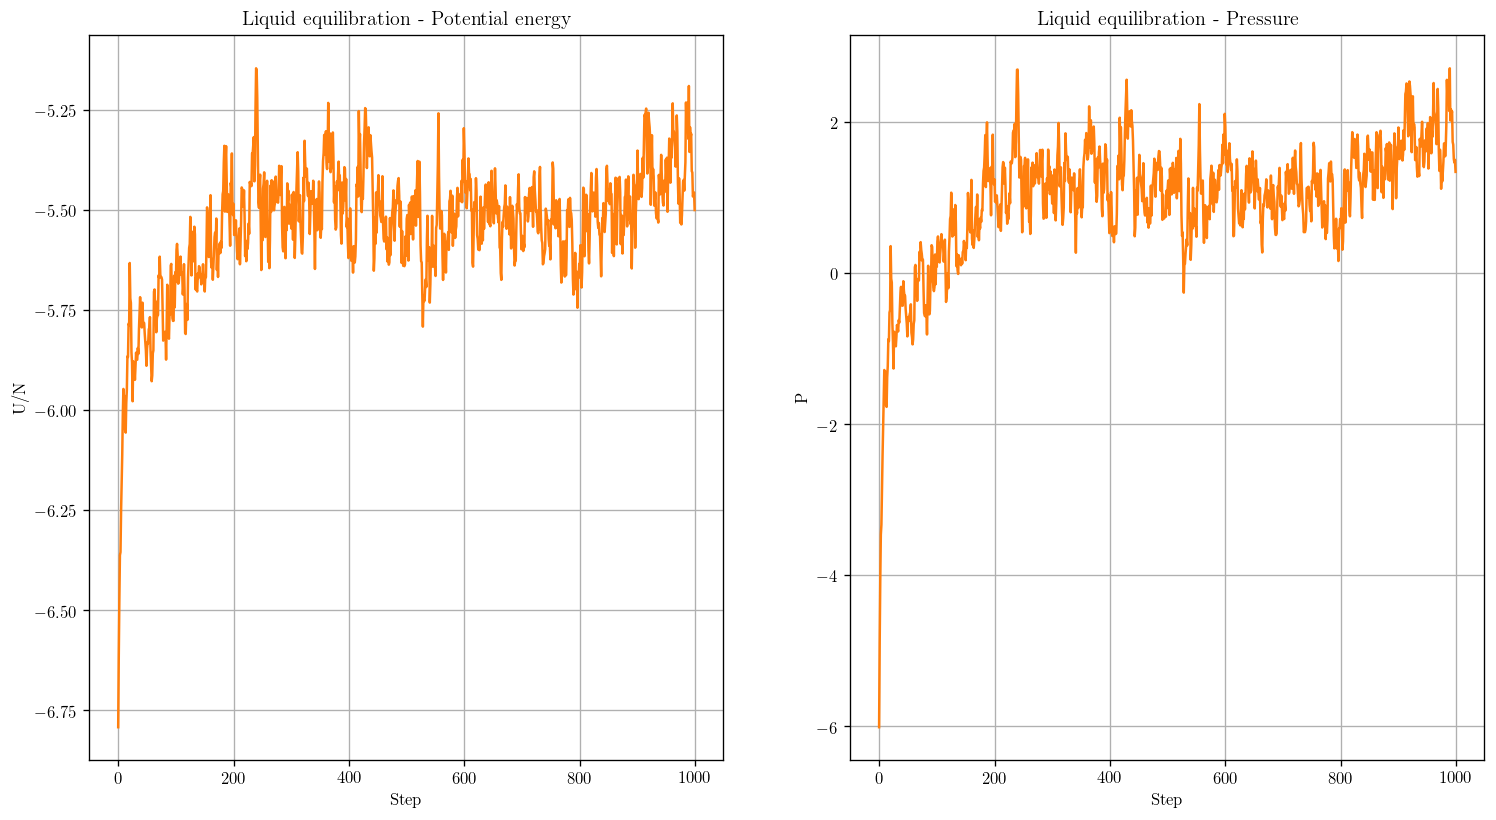

In [3]:
eq_Uinst=np.loadtxt("Ex_07_1/Equilibration/Liquid/output_Uinst.dat", max_rows=1000) #5000 valori nel file
eq_Pinst=np.loadtxt("Ex_07_1/Equilibration/Liquid/output_Pinst.dat", max_rows=1000)


plt.rc('text', usetex=True)
plt.rc('font', family='serif')


fig, ax=plt.subplots(1,2, figsize=(15,8), dpi=120)

ax[0].plot(eq_Uinst,color="C1")
ax[1].plot(eq_Pinst,color="C1")

ax[0].set_title("Liquid equilibration - Potential energy")
ax[1].set_title("Liquid equilibration - Pressure")
ax[0].set_ylabel("U/N")
ax[0].set_xlabel("Step")
ax[1].set_ylabel("P")
ax[1].set_xlabel("Step")
ax[0].grid(True)
ax[1].grid(True)
    
plt.show()

Il sistema si può considerare in equilibro dopo circa <span style="color:red">$N_{eq}=500$ step</span>.

### Gas

Per il gas ho considerato <span style="color:red">$\delta=3.5$, ottenendo $\langle \alpha \rangle \approx 65 \%$</span>. In questo caso anche aumentando molto il passo, l'acceptance rate non cambia radicalmente, rimanendo sempre sopra il $65 \%$. Questo è ragionevole: la fase gassosa è più disordinata, quindi il numero di configurazioni a disposizione è maggiore rispetto alla fase liquida o alla fase solida e risulta più facile estrarne una "buona". Bisogna anche considerare che il box di simulazione ha delle dimensioni finite, quindi anche la dimensione dei passi che si può fare è limitata.

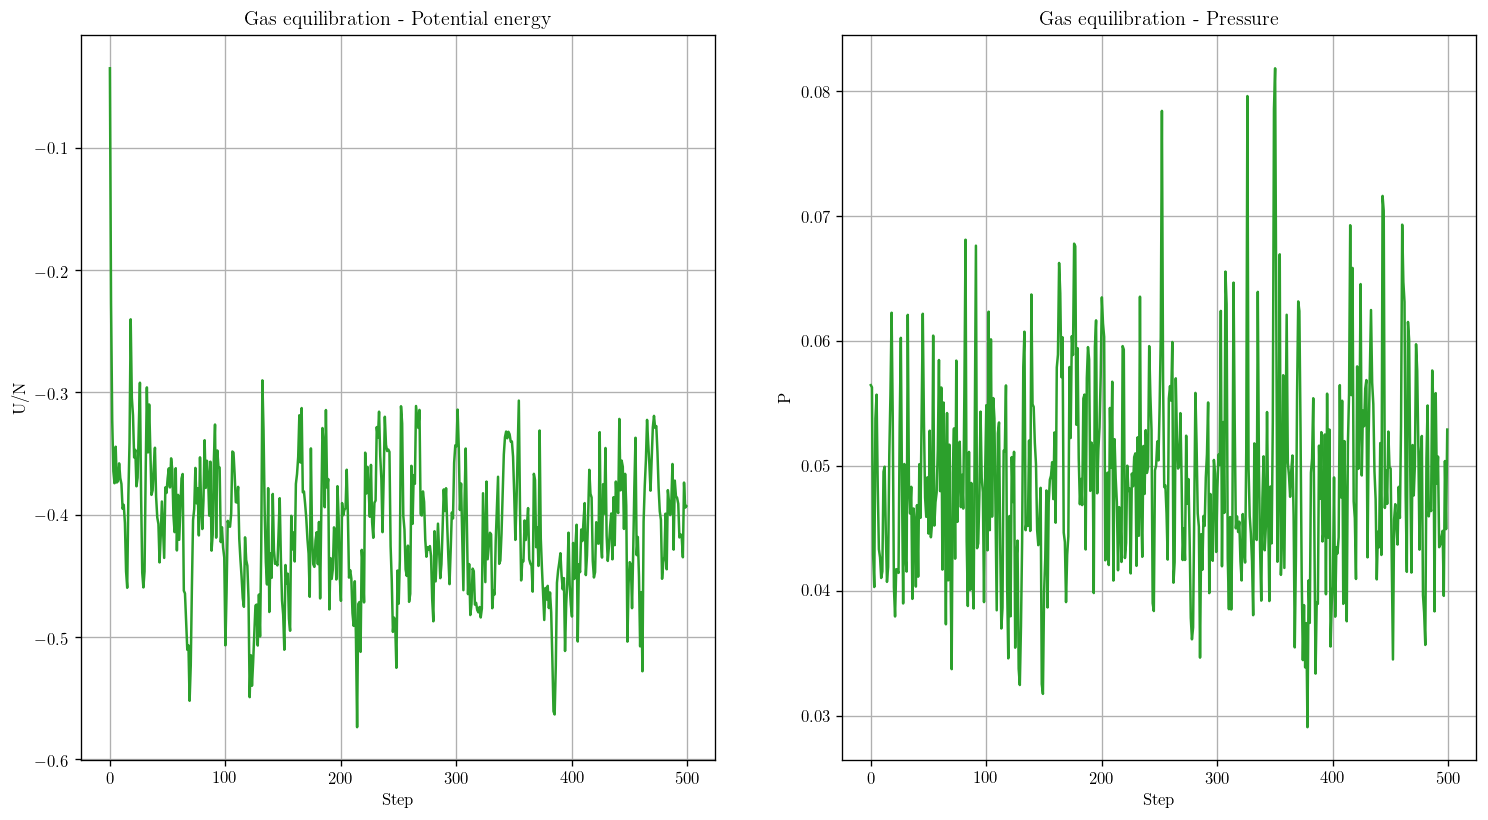

In [4]:
eq_Uinst=np.loadtxt("Ex_07_1/Equilibration/Gas/output_Uinst.dat", max_rows=500) #5000 valori nel file
eq_Pinst=np.loadtxt("Ex_07_1/Equilibration/Gas/output_Pinst.dat", max_rows=500)


plt.rc('text', usetex=True)
plt.rc('font', family='serif')


fig, ax=plt.subplots(1,2, figsize=(15,8), dpi=120)

ax[0].plot(eq_Uinst,color="C2")
ax[1].plot(eq_Pinst,color="C2")

ax[0].set_title("Gas equilibration - Potential energy")
ax[1].set_title("Gas equilibration - Pressure")
ax[0].set_ylabel("U/N")
ax[0].set_xlabel("Step")
ax[1].set_ylabel("P")
ax[1].set_xlabel("Step")
ax[0].grid(True)
ax[1].grid(True)
    
plt.show()

Si nota che già dopo circa <span style="color:red">$N_{eq}=200$</span> passi il sistema si trova in equilibrio. Nei prossimi paragrafi, le misure verranno effettuate dopo 200 passi di equilibrazione.

Le simulazioni nei prossimi paragrafi sono state fatte con il numero di passi di equilibrazione indicato per ogni fase.

## Autocorrelazione e data blocking

Ho provato a implementare il calcolo dell'autocorrelazione autonomamente (la funzione "autocorrelation" definita sotto), ma risultava molto lento. Pertanto mi sono affidato alle funzioni "già pronte" di Python (la funzione "autocorrelation2" definita sotto).

In [5]:
def autocorrelation(v,t,tmax=int(5e5)): #v is the array of measurements
    zipped = zip(v[: tmax-t], v[t:tmax]) #tuple with original array and the one shifted of t
    sum1=0 #sum v(t')*v(t'+t) from t'=0 to t'=tmax-t
    sum2=0 #sum v(t') from t'=0 to tmax-t
    sum3=0 #sum v(t'+t) from t'=0 to tmax-t
    sum4=0 #sum v^2(t') from t'=0 to tmax
    sum5=0 #sum v(t') from t'=0 to tmax
    for v1,v2 in zipped: #v1 is evaluated at t', v2 is evaluated at t'+t
        sum1+=v1*v2
        sum2+=v1
        sum3+=v2    
    for v1 in v[:tmax]:
        sum4+=v1**2
        sum5+=v1
        
    chi=(1./(tmax-t)*sum1-1./(tmax-t)*sum2*1./(tmax-t)*sum3)/(1./tmax*sum4-(1./tmax*sum5)**2)
    return chi

def autocorrelation2(v,t): #Molto più veloce rispetto all'altra implementazione
    tmax=len(v)
    v1=v[:tmax-t]
    v2=v[t:tmax]
    corr_matr=np.corrcoef(v1,v2)
    return corr_matr[0,1]

In [6]:
u_inst_solid=np.loadtxt("Ex_07_1/InstantaneousValues/output_Uinst.solid")
p_inst_solid=np.loadtxt("Ex_07_1/InstantaneousValues/output_Pinst.solid")
u_inst_liquid=np.loadtxt("Ex_07_1/InstantaneousValues/output_Uinst.liquid")
p_inst_liquid=np.loadtxt("Ex_07_1/InstantaneousValues/output_Pinst.liquid")
u_inst_gas=np.loadtxt("Ex_07_1/InstantaneousValues/output_Uinst.gas")
p_inst_gas=np.loadtxt("Ex_07_1/InstantaneousValues/output_Pinst.gas")

In [7]:
time_step=1 #time step for autocorrelation evaluation
tmax=500 #max time for autocorrelation evaluation
t_array=np.arange(0,tmax,time_step)
autocorr_u_solid=[autocorrelation2(u_inst_solid,t) for t in t_array]
autocorr_p_solid=[autocorrelation2(p_inst_solid,t) for t in t_array]
autocorr_u_liquid=[autocorrelation2(u_inst_liquid,t) for t in t_array]
autocorr_p_liquid=[autocorrelation2(p_inst_liquid,t) for t in t_array]
autocorr_u_gas=[autocorrelation2(u_inst_gas,t) for t in t_array]
autocorr_p_gas=[autocorrelation2(p_inst_gas,t) for t in t_array]

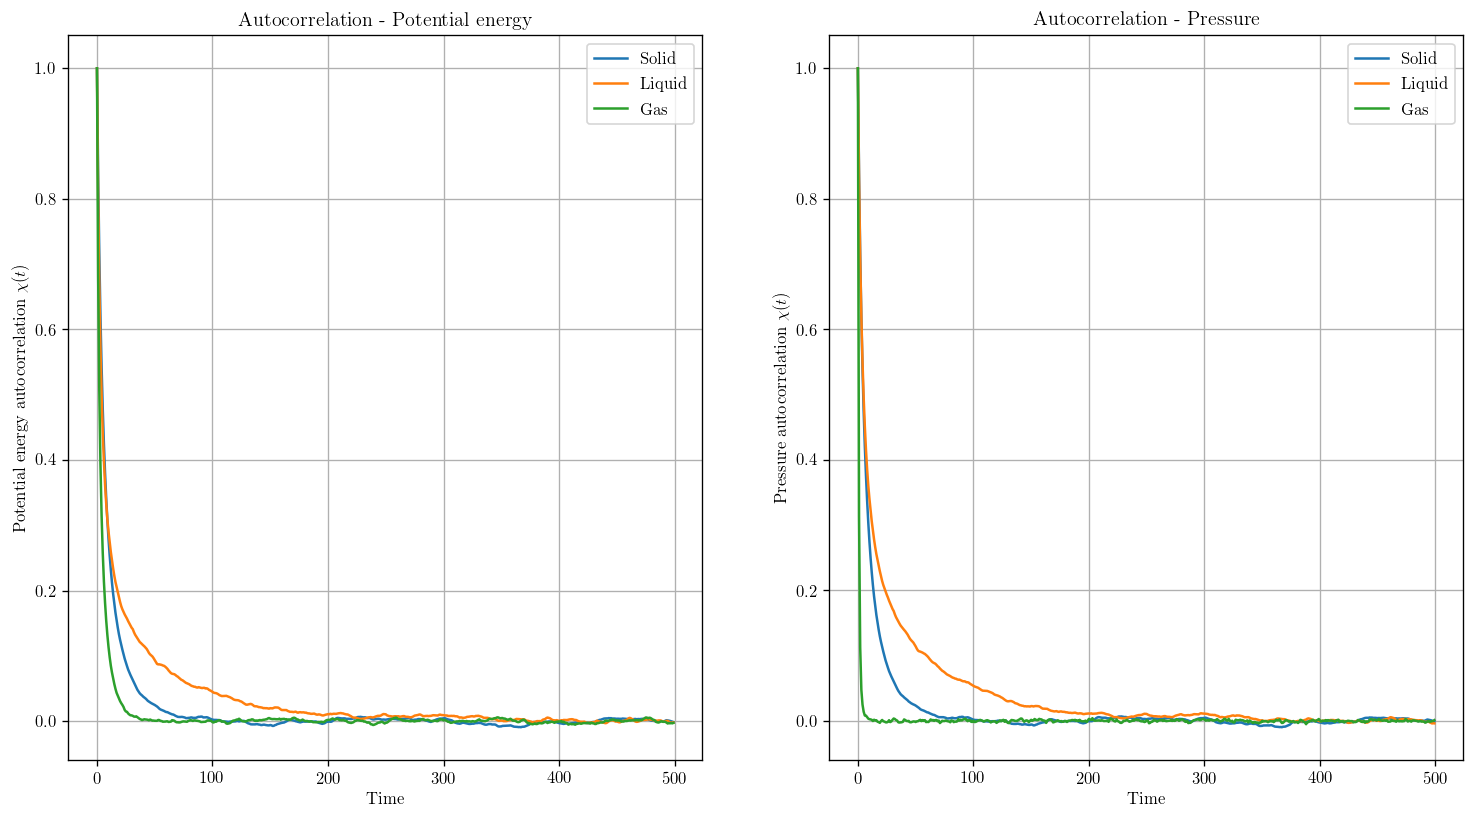

In [8]:
fig, ax=plt.subplots(1,2, figsize=(15,8), dpi=120)

ax[0].plot(t_array, autocorr_u_solid, label="Solid")
ax[0].plot(t_array, autocorr_u_liquid, label="Liquid")
ax[0].plot(t_array, autocorr_u_gas, label="Gas")

ax[1].plot(t_array, autocorr_p_solid, label="Solid")
ax[1].plot(t_array, autocorr_p_liquid, label="Liquid")
ax[1].plot(t_array, autocorr_p_gas, label="Gas")

ax[0].set_title("Autocorrelation - Potential energy")
ax[1].set_title("Autocorrelation - Pressure")
ax[0].set_ylabel(r"Potential energy autocorrelation $\chi(t)$")
ax[0].set_xlabel("Time")
ax[1].set_ylabel(r"Pressure autocorrelation $\chi(t)$")
ax[1].set_xlabel("Time")
ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()

    
plt.show()

Sono sopra riportati i grafici dell'autocorrelazione per l'energia potenziale e la pressione. Si può osservare che <span style="color:red">in ciascuna delle tre fasi l'autocorrelazione di entrambe le grandezze diminuisce molto velocemente diventando pressoché nulla. Dopo un certo periodo di passi oscilla attorno al valore nullo</span>. La fase solida è quella per cui l'autocorrelazione diminuisce più velocemente, mentre la fase liquida è quella per cui diminuisce più lentamente.

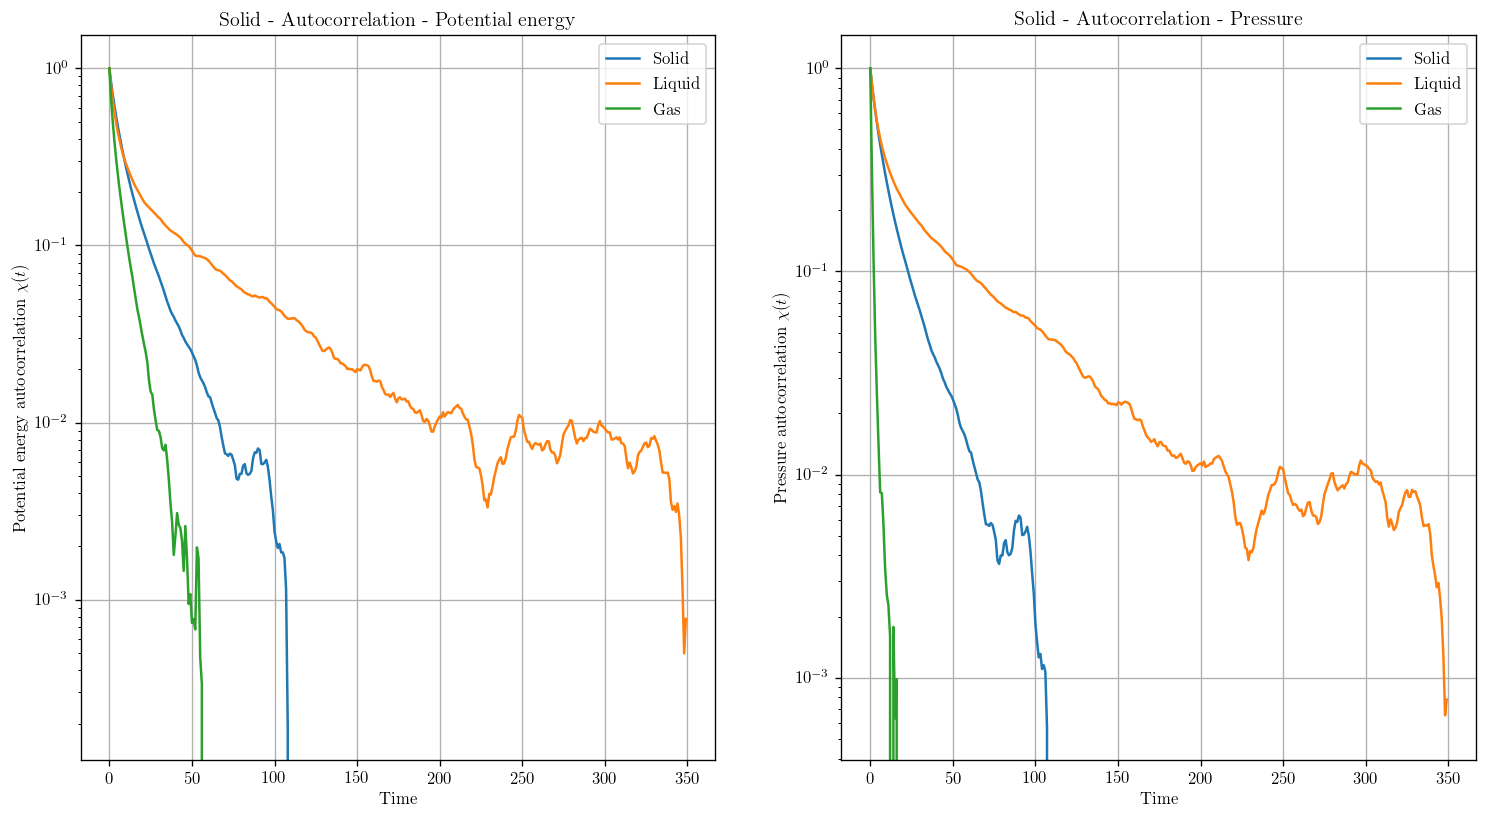

In [9]:
fig, ax=plt.subplots(1,2, figsize=(15,8), dpi=120)

ax[0].plot(t_array[:120], autocorr_u_solid[:120], label="Solid")
ax[0].plot(t_array[:350], autocorr_u_liquid[:350], label="Liquid")
ax[0].plot(t_array[:60], autocorr_u_gas[:60], label="Gas")

ax[1].plot(t_array[:120], autocorr_p_solid[:120], label="Solid")
ax[1].plot(t_array[:350], autocorr_p_liquid[:350], label="Liquid")
ax[1].plot(t_array[:20], autocorr_p_gas[:20], label="Gas")

ax[0].set_yscale('log')
ax[1].set_yscale('log')


ax[0].set_title("Solid - Autocorrelation - Potential energy")
ax[1].set_title("Solid - Autocorrelation - Pressure")
ax[0].set_ylabel(r"Potential energy autocorrelation $\chi(t)$")
ax[0].set_xlabel("Time")
ax[1].set_ylabel(r"Pressure autocorrelation $\chi(t)$")
ax[1].set_xlabel("Time")
ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()

plt.show()

In questi grafici ho riportato le autocorrelazioni in scala logaritmica, escludendo dal grafico i valori successivi alla diminuzione verticale. I dati successivi non risultano interessanti in quanto oscillano attorno al valore nullo (ovvero non c'è più autocorrelazione) e, pertanto, avrebbero disturbato la visualizzazione del grafico.

Si può osservare come il <span style="color:red">decadimento</span> sia <span style=color:red>esponenziale (ovvero lineare in scala logaritmica) per un certo lasso di tempo</span>, mentre non sembra esserlo all'inizio e alla fine: <span style="color:red">dopo un certo tempo</span>, diverso in ognuno dei tre casi ma simile sia per l'energia potenziale che per la pressione, <span style="color:red">l'autocorrelazione diminuisce drasticamente</span>. Da questi grafici si può quindi avere un'idea della lunghezza minima necessaria dei blocchi in cui suddividere i dati per valutare le incertezze con il data blocking (indicativamente $60$ step per la fase gassosa, $350$ per la fase liquida e $120$ per la fase solida). Infatti, l'idea alla base del data blocking è proprio quella di dividere le misure effettuate in blocchi i cui valori medi non siano correlati. Se i valori dei diversi blocchi sono correlati, l'incertezza finale sarà sottostimata, mentre se sono sufficientemente lunghi allora l'incertezza finale non dipenderà dal numero di blocchi considerati (e la sua stima è quindi corretta).

Per verificare quest'ultima osservazione, è possibile studiare come cambia l'incertezza finale al variare della lunghezza dei blocchi considerati, a parità di dati considerati. In realtà non ho considerato esattamente lo stesso numero di dati per ogni lunghezza dei blocchi, dato che sarebbe impossibile a meno di considerare esclusivamente delle lunghezze che dividono esattamente il numero di dati totali. In ogni caso, se si suppone che il numero di dati considerati $M$ è molto maggiore rispetto alla lunghezza dei blocchi $L$, questa "imprecisione" è trascurabile, dato che vengono trascurati al massimo $L$ dati. 

In [10]:
def error(v, L):
    M=len(v)
    N=M//L #number of blocks, N*L \approx M
    avg = 0
    avg2 = 0
    block_values = [np.mean(v[i*L:(i+1)*L]) for i in range(N)]
    err=np.sqrt(np.var(block_values)/(N-1))
    return err

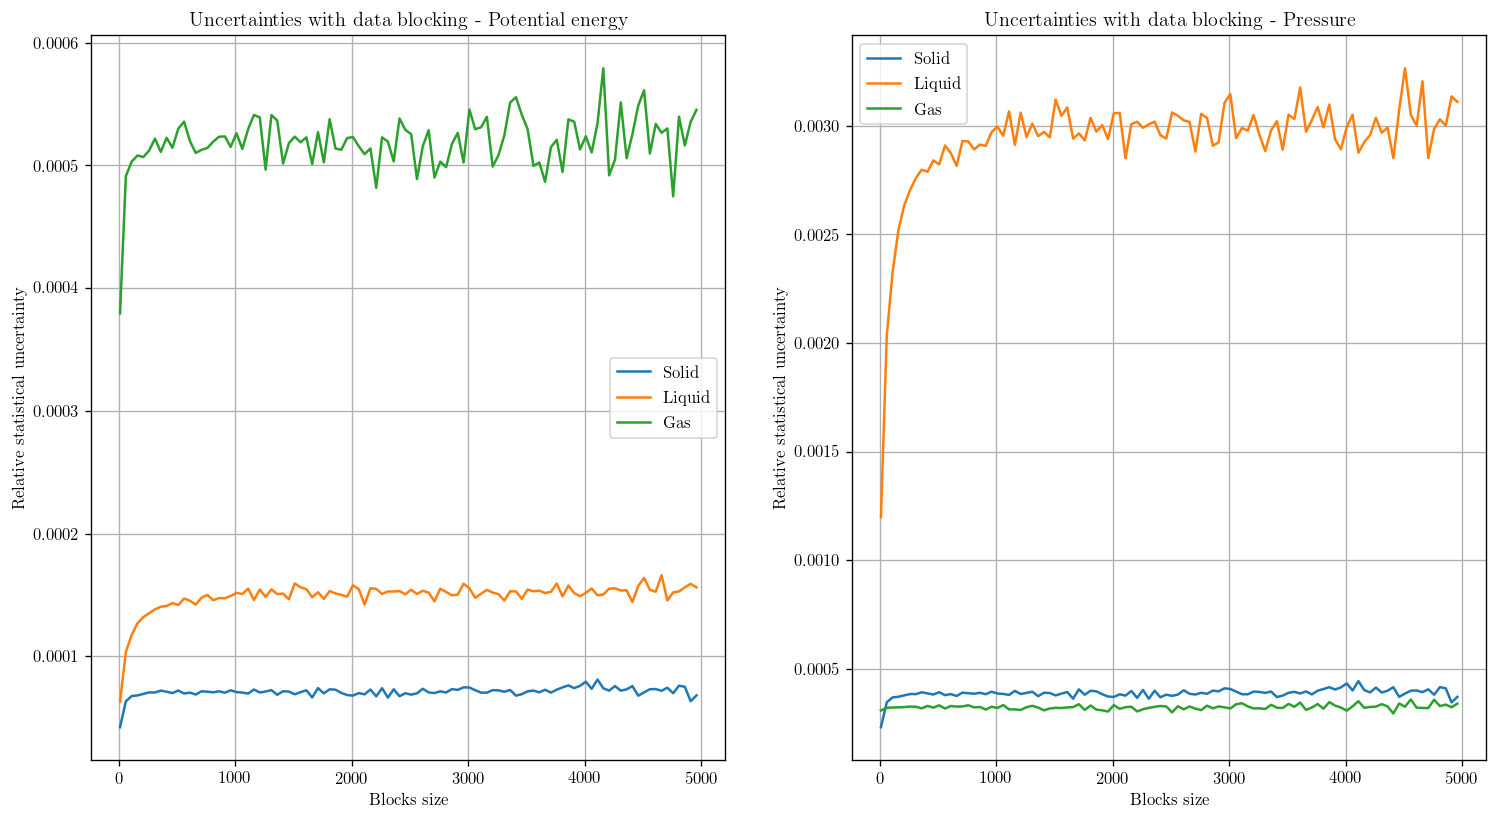

In [11]:
L_array=np.arange(10,5000,50)

error_u_solid=[error(u_inst_solid,Li) for Li in L_array]
error_p_solid=[error(p_inst_solid,Li) for Li in L_array]
error_u_liquid=[error(u_inst_liquid,Li) for Li in L_array]
error_p_liquid=[error(p_inst_liquid,Li) for Li in L_array]
error_u_gas=[error(u_inst_gas,Li) for Li in L_array]
error_p_gas=[error(p_inst_gas,Li) for Li in L_array]

fig, ax=plt.subplots(1,2, figsize=(15,8), dpi=120)

u_solid_ave=u_inst_solid.mean()
u_liquid_ave=u_inst_liquid.mean()
u_gas_ave=u_inst_gas.mean()
p_solid_ave=p_inst_solid.mean()
p_liquid_ave=p_inst_liquid.mean()
p_gas_ave=p_inst_gas.mean()

ax[0].plot(L_array, np.abs(error_u_solid/u_solid_ave), label="Solid")
ax[0].plot(L_array, np.abs(error_u_liquid/u_liquid_ave), label="Liquid")
ax[0].plot(L_array, np.abs(error_u_gas/u_gas_ave), label="Gas")

ax[1].plot(L_array, np.abs(error_p_solid/p_solid_ave), label="Solid")
ax[1].plot(L_array, np.abs(error_p_liquid/p_liquid_ave), label="Liquid")
ax[1].plot(L_array, np.abs(error_p_gas/p_gas_ave), label="Gas")

ax[0].set_title("Uncertainties with data blocking - Potential energy")
ax[1].set_title("Uncertainties with data blocking - Pressure")
ax[0].set_ylabel(r"Relative statistical uncertainty")
ax[0].set_xlabel("Blocks size")
ax[1].set_ylabel(r"Relative statistical uncertainty")
ax[1].set_xlabel("Blocks size")
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)


Nei grafici soprastanti ho rappresentato la stima delle incertezze relative per l'energia potenziale e la pressione per ognuna delle tre fasi al variare della dimensione dei blocchi considerati. Effettivamente, <span style="color:red">l'incertezza cresce con l'aumentare della taglia dei blocchi quando questi sono ottenuti con pochi dati; considerando un maggior numero di misure per blocco, invece, i valori delle incertezze risultano pressoché costanti. Il motivo della crescita iniziale consiste nel fatto che per valori correlati non è possibile applicare il teorema del limite centrale</span>. Una volta raggiunta una dimensione dei blocchi tale per cui essi si possono considerare non correlati, il valore dell'incertezza non dipende più dal numero di dati con cui si sono ottenuti i valori dei blocchi.

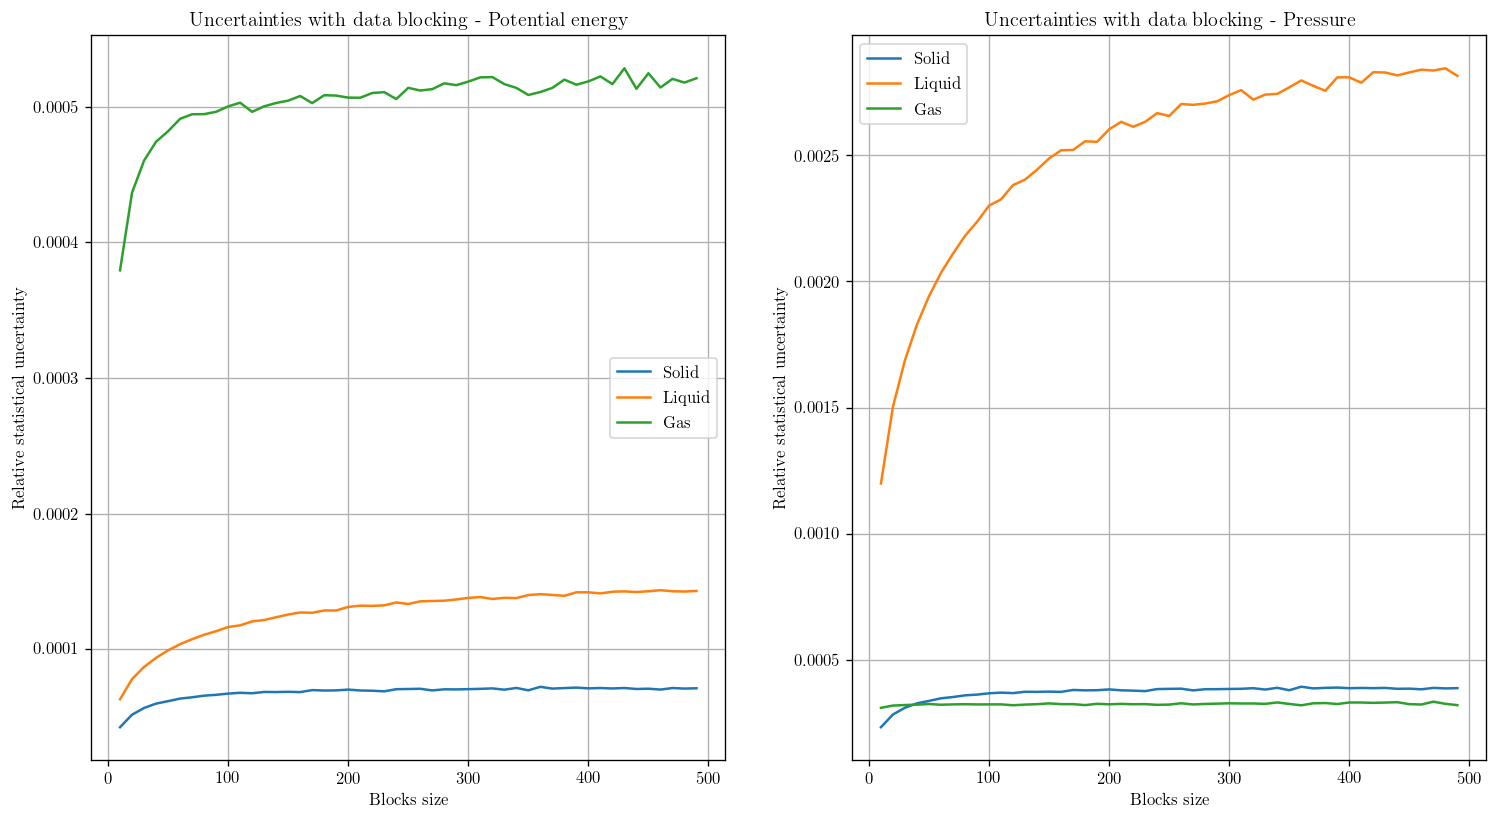

In [12]:
L_array=np.arange(10,500,10)

error_u_solid=[error(u_inst_solid,Li) for Li in L_array]
error_p_solid=[error(p_inst_solid,Li) for Li in L_array]
error_u_liquid=[error(u_inst_liquid,Li) for Li in L_array]
error_p_liquid=[error(p_inst_liquid,Li) for Li in L_array]
error_u_gas=[error(u_inst_gas,Li) for Li in L_array]
error_p_gas=[error(p_inst_gas,Li) for Li in L_array]

fig, ax=plt.subplots(1,2, figsize=(15,8), dpi=120)

u_solid_ave=u_inst_solid.mean()
u_liquid_ave=u_inst_liquid.mean()
u_gas_ave=u_inst_gas.mean()
p_solid_ave=p_inst_solid.mean()
p_liquid_ave=p_inst_liquid.mean()
p_gas_ave=p_inst_gas.mean()

ax[0].plot(L_array, np.abs(error_u_solid/u_solid_ave), label="Solid")
ax[0].plot(L_array, np.abs(error_u_liquid/u_liquid_ave), label="Liquid")
ax[0].plot(L_array, np.abs(error_u_gas/u_gas_ave), label="Gas")

ax[1].plot(L_array, np.abs(error_p_solid/p_solid_ave), label="Solid")
ax[1].plot(L_array, np.abs(error_p_liquid/p_liquid_ave), label="Liquid")
ax[1].plot(L_array, np.abs(error_p_gas/p_gas_ave), label="Gas")

ax[0].set_title("Uncertainties with data blocking - Potential energy")
ax[1].set_title("Uncertainties with data blocking - Pressure")
ax[0].set_ylabel(r"Relative statistical uncertainty")
ax[0].set_xlabel("Blocks size")
ax[1].set_ylabel(r"Relative statistical uncertainty")
ax[1].set_xlabel("Blocks size")
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)


Focalizzando l'attenzione sulla parte iniziale dei grafici sopra riportati (ovvero considerando dimensioni dei blocchi piccole), si può notare come <span style="color:red">i valori per cui l'autocorrelazione crolla (da cui avevamo desunto una possibile dimensione per i blocchi) sono effettivamente confrontabili con il numero minimo di dati da considerare per ogni blocco affinché l'incertezza si stabilizzi</span>. Anche l'andamento qualitativo delle incertezze per le varie fasi è coerente. Si può infatti notare che l'incertezza sulla fase liquida è quella che cresce più lentamente con la taglia dei blocchi (così come la sua autocorrelzione diminuiva più lentamente rispetto alle altre due fasi). Un ultimo dettagli che si può notare riguarda la fase gassosa: la drastica diminuzione dell'autocorrelazione si verificava prima per la pressione (dopo circa $25$ step) che per l'energia potenziale (dopo circa $60$ step); la stessa differenza si può osservare nei grafici soprastanti.

<span style="color:red">Nel seguito</span>, per il campionamento dell'ensemble canonico, sono stati considerati <span style="color:red">$2000$ step per blocco, per un totale di $50$ blocchi</span>. 

## Funzione di distribuzione radiale

Ho implementato il calcolo della funzione di distribuzione radiale, sia nel codice <span style="color:orange">per l'insieme canonico (Monte Carlo)</span>, sia in quello <span style="color:green">per l'insieme microcanonico (Molecular Dynamics)</span>. Si noti che l'approccio dei due algoritmi considerati è completamente diverso: nel primo caso <span style="color:orange">vengono campionate delle configurazioni da una certa distribuzione di probabilità</span> (determinata dai pesi di Boltzmann), nel secondo caso <span style="color:green">vengono invece fatte evolvere delle particelle secondo le equazioni della dinamica e vengono seguite nel tempo</span>. Quindi, nel primo caso vengono effettuate delle <span style="color:orange">medie di ensemble</span>, mentre nel secondo caso delle <span style="color:green">medie nel tempo</span>. Il fatto che, sotto certe condizioni, queste due diverse medie siano equivalenti è alla base della meccanica statistica</span>.

La funzione di distribuzione radiale $g(r)$ dà una descrizione della struttura del sistema in esame e consente di calcolare u valori di aspettazione di grandezze macroscopiche "a coppie". Rappresenta la probabilità di trovare una coppia di particelle a distanza $r$ rispetto al caso di un gas ideale (per cui le particelle sono distribuite uniformemente). Per calcolare $g(r)$ data una certa configurazione basta "contare" le particelle che si trovano a una distanza compresa tra $r$ e $r+dr$, ovvero realizzare un istogramma, che poi andrà correttamente normalizzato. Nello specifico, <span style="color:red">per il calcolo di $g(r)$ ho considerato 200 bin</span>.

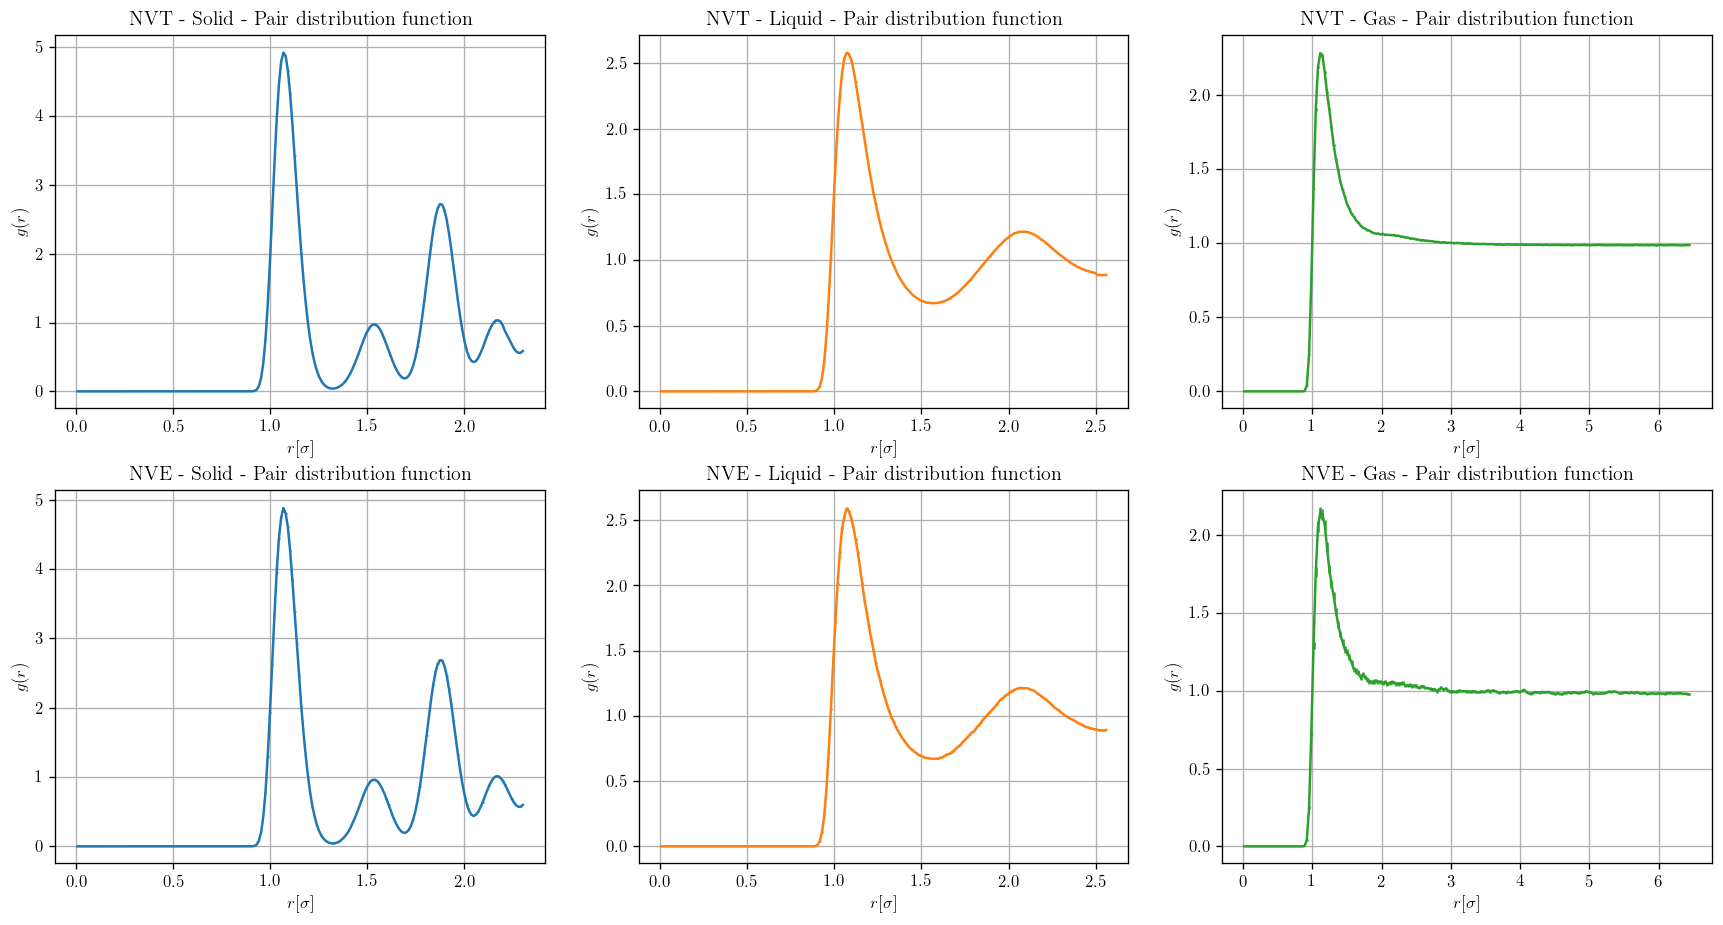

In [13]:
left_solid, right_solid, g_solid, err_g_solid=np.loadtxt("Ex_07_2/PairDistribution/output.gave.solid", delimiter=",", skiprows=1, dtype="float,float,float, float", unpack=True)
left_solid, right_solid, gmd_solid, err_gmd_solid=np.loadtxt("Ex_07_3/Solid/output.gave.0", delimiter=",", skiprows=1, dtype="float,float,float, float", unpack=True)
left_liquid, right_liquid, g_liquid, err_g_liquid=np.loadtxt("Ex_07_2/PairDistribution/output.gave.liquid", delimiter=",", skiprows=1, dtype="float,float,float, float", unpack=True)
left_liquid, right_liquid, gmd_liquid, err_gmd_liquid=np.loadtxt("Ex_07_3/Liquid/output.gave.0", delimiter=",", skiprows=1, dtype="float,float,float, float", unpack=True)
left_gas, right_gas, g_gas, err_g_gas=np.loadtxt("Ex_07_2/PairDistribution/output.gave.gas", delimiter=",", skiprows=1, dtype="float,float,float, float", unpack=True)
left_gas, right_gas, gmd_gas, err_gmd_gas=np.loadtxt("Ex_07_3/Gas/output.gave.0", delimiter=",", skiprows=1, dtype="float,float,float, float", unpack=True)

center_solid=(left_solid+right_solid)/2
center_liquid=(left_liquid+right_liquid)/2
center_gas=(left_gas+right_gas)/2

g=[g_solid,g_liquid,g_gas]
err_g=[err_g_solid,err_g_liquid,err_g_gas]
center=[center_solid, center_liquid, center_gas]

fig, (ax1,ax2)=plt.subplots(2,3, figsize=(15,8), dpi=120)
fig.tight_layout(pad=3.0)


for i in range(3):
    ax1[i].grid(True)
    ax1[i].set_xlabel(r"$r[\sigma]$")
    ax1[i].set_ylabel(r"$g(r)$")
    ax2[i].grid(True)
    ax2[i].set_xlabel(r"$r[\sigma]$")
    ax2[i].set_ylabel(r"$g(r)$")
    
ax1[0].errorbar(center_solid,g_solid,err_g_solid)
ax1[0].set_title("NVT - Solid - Pair distribution function")
ax2[0].errorbar(center_solid,gmd_solid,err_gmd_solid)
ax2[0].set_title("NVE - Solid - Pair distribution function")

ax1[1].errorbar(center_liquid,g_liquid,err_g_liquid,color="C1")
ax1[1].set_title("NVT - Liquid - Pair distribution function")
ax2[1].set_title("NVE - Liquid - Pair distribution function")
ax2[1].errorbar(center_liquid,gmd_liquid,err_gmd_liquid, color="C1")

ax1[2].errorbar(center_gas,g_gas,err_g_gas,color="C2")
ax1[2].set_title("NVT - Gas - Pair distribution function")
ax2[2].errorbar(center_gas,gmd_gas,err_gmd_gas,color="C2")
ax2[2].set_title("NVE - Gas - Pair distribution function")


plt.show()


Nei tre grafici sopra sono riportati il calcolo della funzione di distribuzione radiale calcolata per le tre fasi con un campionamento Monte Carlo dell'insieme canonico; sotto sono riportati i risultati ottenuti nell'insieme microcanonico con il codice di Molecular Dynamics. In questo secondo caso, ho considerato le stesse condizioni utilizzate nell'esercitazione 4. I due ensemble considerati sono diversi, nell'ensemble canonico è fissata la temperatura (mentre l'energia interna no), invece, nell'ensemble microcanonico, è fissata l'energia (ma non la temperatura). Non bisogna quindi attendersi che i valori ottenuti nelle due simulazioni siano compatibili entro le incertezze statistiche perché corrispondono a situazioni diverse (questo vale anche per tutte le grandezze considerate successivamente); l'equivalenza tra i due ensemble si avrebbe soltanto nel limite termodinamico $N\to +\infty$ (mentre noi abbiamo considerato $N=108$), quando le fluttuazione dell'energia nell'insieme canonico vanno a zero.

Nonostante queste considerazioni, è comunque interessante fare un confronto qualitativo tra le funzioni $g(r)$ ottenute. Infatti, le simulazioni nell'insieme microcanonico sono state fatte termalizzando il sistema, ovvero portandolo intorno a una temperatura target, che è quella che è stata considerata per il campionamente dell'insieme canonico. In questo caso, dunque, è lecito attendersi che anche microscopicamente i due sistemi considerati siano simili. Questo è esattamente quello che ci dimostrano le funzioni di distribuzione radiale sopra riportate. <span style="color:red">Confrontando le $g(r)$ corrispondenti alla stessa fase, non si riscontrano significative differenze qualitative: a parità di condizione termodinamiche, la distribuzione della distanza tra particelle è analoga per i due algoritmi</span>.

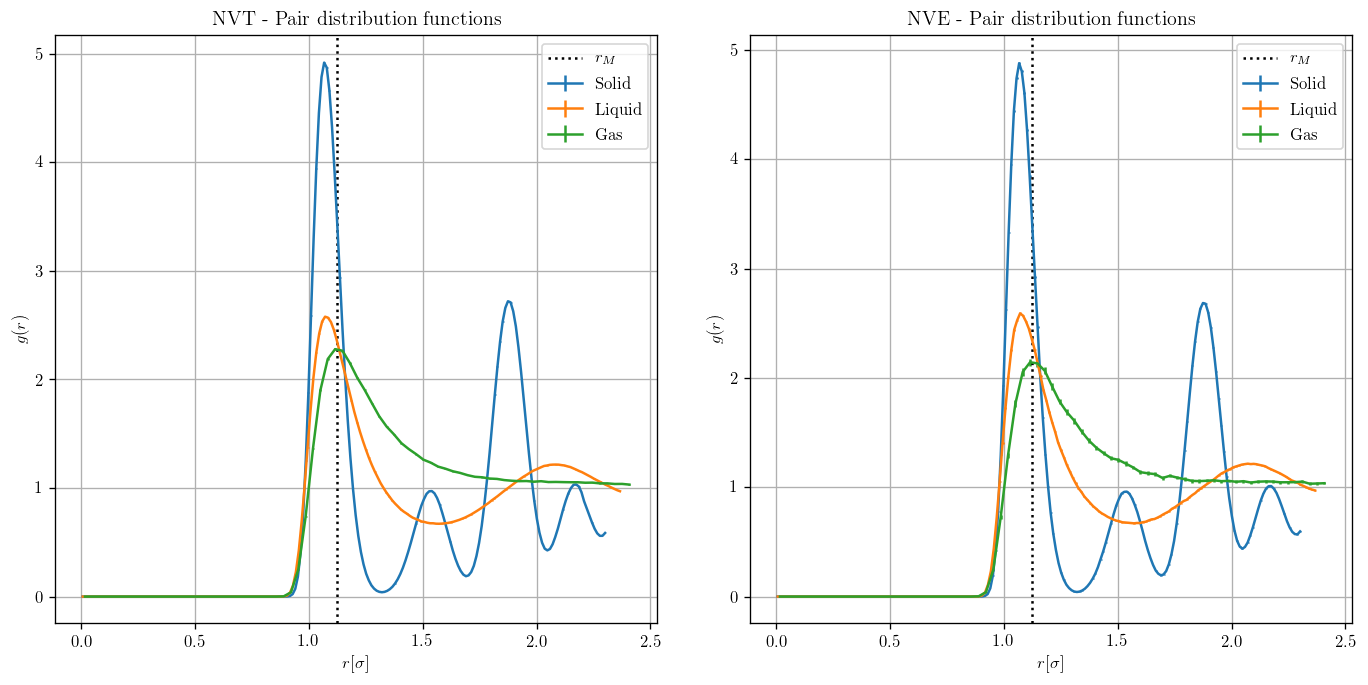

In [14]:
left_solid, right_solid, g_solid, err_g_solid=np.loadtxt("Ex_07_2/PairDistribution/output.gave.solid", delimiter=",", skiprows=1, dtype="float,float,float, float", unpack=True)
left_solid, right_solid, gmd_solid, err_gmd_solid=np.loadtxt("Ex_07_3/Solid/output.gave.0", delimiter=",", skiprows=1, dtype="float,float,float, float", unpack=True)
left_liquid, right_liquid, g_liquid, err_g_liquid=np.loadtxt("Ex_07_2/PairDistribution/output.gave.liquid", delimiter=",", skiprows=1, dtype="float,float,float, float", unpack=True)
left_liquid, right_liquid, gmd_liquid, err_gmd_liquid=np.loadtxt("Ex_07_3/Liquid/output.gave.0", delimiter=",", skiprows=1, dtype="float,float,float, float", unpack=True)
left_gas, right_gas, g_gas, err_g_gas=np.loadtxt("Ex_07_2/PairDistribution/output.gave.gas", delimiter=",", skiprows=1, dtype="float,float,float, float", unpack=True)
left_gas, right_gas, gmd_gas, err_gmd_gas=np.loadtxt("Ex_07_3/Gas/output.gave.0", delimiter=",", skiprows=1, dtype="float,float,float, float", unpack=True)

center_solid=(left_solid+right_solid)/2
center_liquid=(left_liquid+right_liquid)/2
center_gas=(left_gas+right_gas)/2

g=[g_solid,g_liquid,g_gas]
err_g=[err_g_solid,err_g_liquid,err_g_gas]
center=[center_solid, center_liquid, center_gas]

fig, (ax1,ax2)=plt.subplots(1,2, figsize=(12,6), dpi=120)
fig.tight_layout(pad=3.0)


ax1.grid(True)
ax1.set_xlabel(r"$r[\sigma]$")
ax1.set_ylabel(r"$g(r)$")
ax1.set_title("NVT - Pair distribution functions")
ax2.grid(True)
ax2.set_xlabel(r"$r[\sigma]$")
ax2.set_ylabel(r"$g(r)$")
ax2.set_title("NVE - Pair distribution functions")

    
ax1.errorbar(center_solid,g_solid,err_g_solid,label="Solid")
ax2.errorbar(center_solid,gmd_solid,err_gmd_solid,label="Solid")

ax1.errorbar(center_liquid[:185],g_liquid[:185],err_g_liquid[:185],color="C1",label="Liquid")
ax2.errorbar(center_liquid[:185],gmd_liquid[:185],err_gmd_liquid[:185], color="C1",label="Liquid")

ax1.errorbar(center_gas[:75],g_gas[:75],err_g_gas[:75],color="C2",label="Gas")
ax2.errorbar(center_gas[:75],gmd_gas[:75],err_gmd_gas[:75],color="C2",label="Gas")

ax1.axvline(1.122,0,1, color="black", linestyle="dotted", label=r"$r_M$")
ax2.axvline(1.122,0,1, color="black", linestyle="dotted", label=r"$r_M$")


ax1.legend()
ax2.legend()

plt.show()


Da questi grafici e da quelli precedenti è possibile, come accennato sopra, ricavare delle considerazioni fisiche.
Innanzitutto, si nota che, a prescindere dalla fase, <span style="color:red">tutte le $g(r)$ sono nulle fino a circa $r=\sigma$</span>: questo è dovuto alla parte hard-core del potenziale di Lennard-Jones ($\sigma$ è proprio la distanza alla quale il potenziale di Lennard-Jones cambia di segno), che impedisce la compenetrazione delle particelle. <span style="color:red">Il massimo che si osserva poco dopo corrisponde al minimo del potenziale di Lennard-Jones, che si trova a circa $r\approx 1.122 \sigma$</span>. Si può notare che nella fase liquida e solida il massimo di $g(r)$ si trova un po' prima rispetto alla distanza per cui è minimo il potenziale, questo è dovuto al fatto che in questi due casi non sono più soltanto le interazioni tra primi vicini ad essere rilevanti (conme invece sembra confermare il fatto che il massimo della fase gassosa sia proprio a $r\approx1.122\sigma$).

<span style="color:blue">Per</span> quanto riguarda <span style="color:blue">la fase solida si può osservare l'emergere di una struttura cristallina</span>: si alternano periodicamente distanze a cui è molto probabile trovare una coppia di atomi (rispetto al caso del gas ideale) a zone in cui invece è molto difficile trovarne. Anche <span style="color:orange">nella fase liquida</span> si può notare una certo andamento periodico, a testimonianza del <span style="color:orange">posizionamento "a shell" delle particelle</span>. <span style="color:green">Per</span> quanto riguarda <span style="color:green">la fase gassosa</span>, infine, si può notare che <span style="color:green">a grande distanza $g(r) \approx 1$, ovvero un gas di Lennard-Jones è approssimabile con un gas ideale</span>.

## Energia potenziale e pressione

Riporto ora i risultati ottenuti per il calcolo dell'energia potenziale e della pressione. In questo caso sono state considerate anche le tail corrections.

### Fase solida

Per quanto riguarda le tail corrections, si ottiene $\frac{\Delta V_{tail}}{N}=-0.86 \varepsilon=-1.43\times10^{-21} \; \text{J}$ e $\Delta P_{tail}=-1.90 \frac{\epsilon}{\sigma^3}=-7.98 \times 10^{7} \; \text{Pa}$. <span style="color:red">Le correzioni sono quindi circa del $10 \%$ rispetto al valore calcolato</span>.

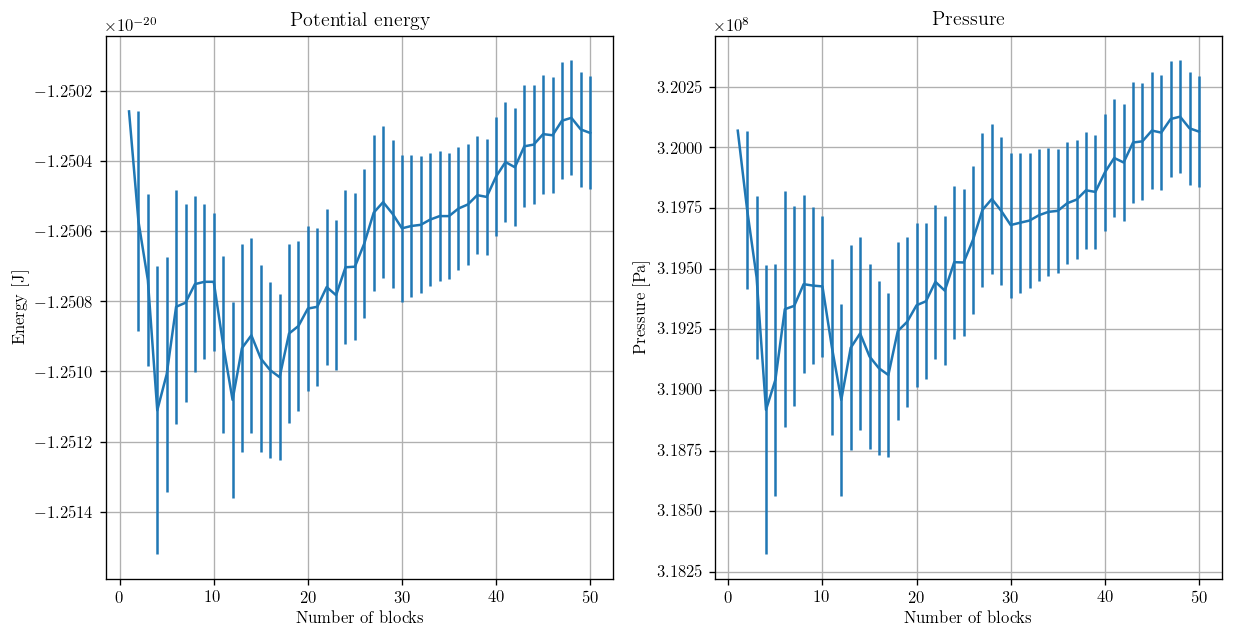

Final potential energy:  -1.25032082230608e-20  +/-  1.609422532023408e-24  J
Final pressure:  320065407.68631786  +/-  228448.99471592504  Pa


In [15]:
import scipy.constants as sc
kb=sc.Boltzmann

sigma=0.34e-09
epsilon=120*kb
presunit=epsilon/sigma**3

nblocks, epot, err_epot = np.loadtxt("Ex_07_4/Solid/output.uave.0", delimiter=",", usecols=(0,1,2), dtype="int,float,float", unpack=True)
nblocks, pres, err_pres = np.loadtxt("Ex_07_4/Solid/output.pave.0", delimiter=",", usecols=(0,1,2), dtype="int,float,float", unpack=True)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')


fig, ax = plt.subplots(1, 2, figsize=(12,6),dpi=120)
ax[0].errorbar(nblocks, epot*epsilon, yerr=err_epot*epsilon, color="C0")
ax[0].set_title("Potential energy")
ax[0].set_ylabel("Energy [J]")
ax[0].set_xlabel("Number of blocks")
ax[0].grid(True)

ax[1].errorbar(nblocks, pres*presunit, yerr=err_pres*presunit, color="C0")
ax[1].set_title("Pressure")
ax[1].set_ylabel("Pressure [Pa]")
ax[1].set_xlabel("Number of blocks")
ax[1].grid(True)

plt.show()
print("Final potential energy: ", epot[-1]*epsilon, " +/- ", err_epot[-1]*epsilon, " J")
print("Final pressure: ", pres[-1]*presunit, " +/- ", err_pres[-1]*presunit, " Pa")



Le stime finali per l'energia potenziale e la pressione sono:
$$ \frac{V}{N}=-1.25032 \pm 0.00016 \; \times 10^{-20} \text{J}$$
$$ P=320.1 \pm 0.2 \; \text{MPa}$$


### Fase liquida

Per quanto riguarda le tail corrections, si ottiene $\frac{\Delta V_{tail}}{N}=-0.43 \varepsilon=-7.10 \times \times10^{-22} \; \text{J}$ e $\Delta P_{tail}=-0.68 \frac{\epsilon}{\sigma^3}=-2.89 \times 10^{7} \; \text{Pa}$. <span style="color:red">La correzione dell'energia è quindi circa del $10 \%$ rispetto al valore calcolato, mentre quella della pressione è addirittura intorno al $50 \%$</span>.

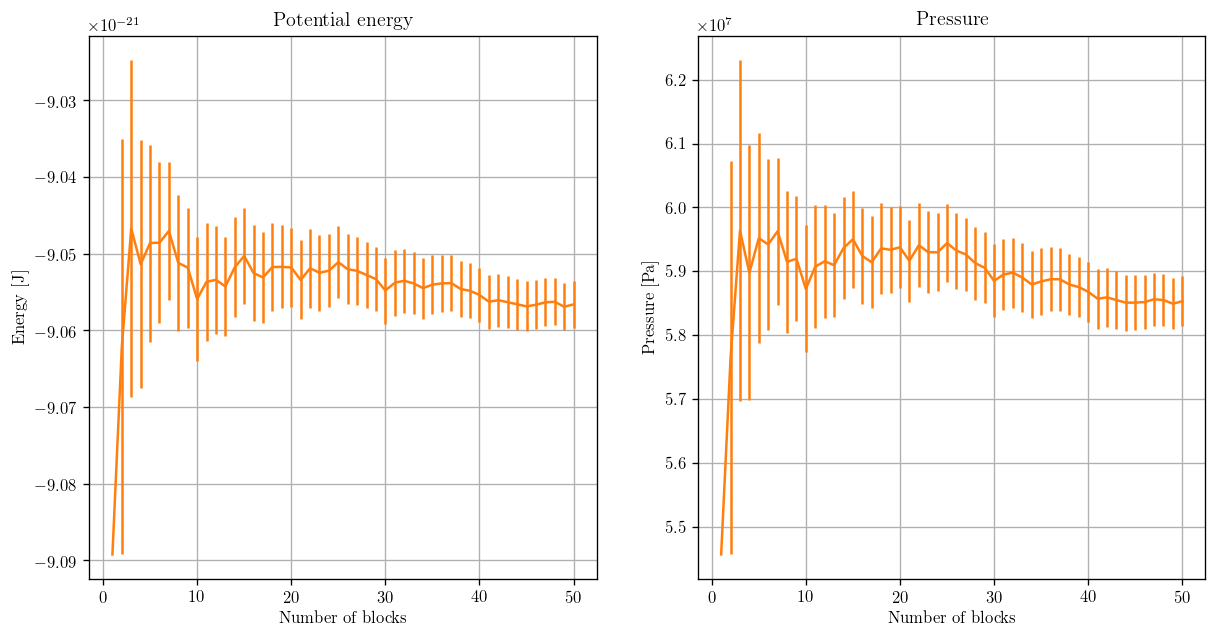

Final potential energy: -9.0566124836736e-21 +/- 3.03757033144608e-24
Final pressure: 58533961.16498675 +/- 395053.75974633824


In [16]:
import scipy.constants as sc
kb=sc.Boltzmann

sigma=0.34e-09
epsilon=120*kb
presunit=epsilon/sigma**3

nblocks, epot, err_epot = np.loadtxt("Ex_07_4/Liquid/output.uave.0", delimiter=",", usecols=(0,1,2), dtype="int,float,float", unpack=True)
nblocks, pres, err_pres = np.loadtxt("Ex_07_4/Liquid/output.pave.0", delimiter=",", usecols=(0,1,2), dtype="int,float,float", unpack=True)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')


fig, ax = plt.subplots(1, 2, figsize=(12,6),dpi=120)
ax[0].errorbar(nblocks, epot*epsilon, yerr=err_epot*epsilon, color="C1")
ax[0].set_title("Potential energy")
ax[0].set_ylabel("Energy [J]")
ax[0].set_xlabel("Number of blocks")
ax[0].grid(True)

ax[1].errorbar(nblocks, pres*presunit, yerr=err_pres*presunit, color="C1")
ax[1].set_title("Pressure")
ax[1].set_ylabel("Pressure [Pa]")
ax[1].set_xlabel("Number of blocks")
ax[1].grid(True)

plt.show()
print("Final potential energy: "+str(epot[-1]*epsilon)+" +/- "+str(err_epot[-1]*epsilon))
print("Final pressure: "+str(pres[-1]*presunit)+" +/- "+str(err_pres[-1]*presunit))

Le stime finali per l'energia potenziale e la pressione sono:
$$ \frac{V}{N}=-9.057 \pm 0.003 \; \times 10^{-21} \text{J}$$
$$ P=58.5 \pm 0.4 \; \text{MPa}$$

### Fase gassosa

Per quanto riguarda le tail corrections, si ottiene $\frac{\Delta V_{tail}}{N}=-3.35 \times 10^{-3}\varepsilon=-5.56 \times \times10^{-24} \; \text{J}$ e $\Delta P_{tail}=-3.35 \times 10^{-4} \frac{\epsilon}{\sigma^3}=-14.1 \; \text{kPa}$. <span style="color:red">In questo caso le correzioni sono nell'ordine dell'$1\%$</span>.

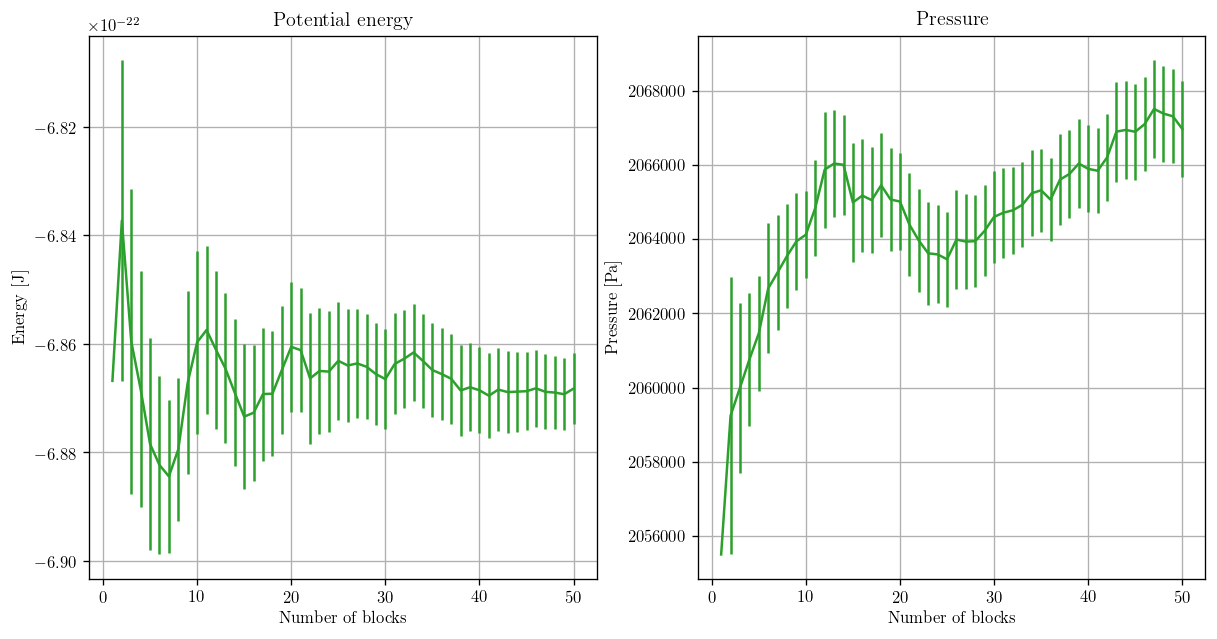

Final potential energy: -6.8682403987209595e-22 +/- 6.608639818802399e-25
Final pressure: 2066972.4682389167 +/- 1286.4395621647056


In [17]:
import scipy.constants as sc
kb=sc.Boltzmann

sigma=0.34e-09
epsilon=120*kb
presunit=epsilon/sigma**3

nblocks, epot, err_epot = np.loadtxt("Ex_07_4/Gas/output.uave.0", delimiter=",", usecols=(0,1,2), dtype="int,float,float", unpack=True)
nblocks, pres, err_pres = np.loadtxt("Ex_07_4/Gas/output.pave.0", delimiter=",", usecols=(0,1,2), dtype="int,float,float", unpack=True)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')


fig, ax = plt.subplots(1, 2, figsize=(12,6),dpi=120)
ax[0].errorbar(nblocks, epot*epsilon, yerr=err_epot*epsilon, color="C2")
ax[0].set_title("Potential energy")
ax[0].set_ylabel("Energy [J]")
ax[0].set_xlabel("Number of blocks")
ax[0].grid(True)

ax[1].errorbar(nblocks, pres*presunit, yerr=err_pres*presunit, color="C2")
ax[1].set_title("Pressure")
ax[1].set_ylabel("Pressure [Pa]")
ax[1].set_xlabel("Number of blocks")
ax[1].grid(True)

plt.show()
print("Final potential energy: "+str(epot[-1]*epsilon)+" +/- "+str(err_epot[-1]*epsilon))
print("Final pressure: "+str(pres[-1]*presunit)+" +/- "+str(err_pres[-1]*presunit))

Le stime finali per l'energia potenziale e la pressione sono:
$$ \frac{V}{N}=-6.868 \pm 0.007 \; \times 10^{-22} \text{J}$$
$$ P=2067.0 \pm 1.3 \; \text{kPa}$$